# Spin-polarised-current-driven domain wall

**Author**: Marijan Beg, Weiwei Wang

**Date**: 18 Mar 2016

This notebook can be downloaded from the github repository, found [here](https://github.com/computationalmodelling/fidimag/blob/master/doc/ipynb/current-driven-domain-wall.ipynb).

### Problem specification

The simulated sample is a 1D nanowire cuboid with $L=1000 \,\text{nm}$ length with finite difference discretisation $d_{x} = d_{y} = d_{z} = 2 \,\text{nm}$.

The material parameters (similar to permalloy) are:
    
- exchange energy constant $A = 1.3 \times 10^{-11} \,\text{J/m}$,
- magnetisation saturation $M_\text{s} = 8.6 \times 10^{5} \,\text{A/m}$,
- uniaxial anisotropy constant $K=5 \times 10^{4} \,\text{J/m}^{3}$ with $(0, 0, 1)$ easy-axis,
- Gilbert damping $\alpha = 0.5$.

After the system is relaxed to a domain wall, a spin-polarised current with $J=1 \times 10^{12} \text{A/m}^{2}$ density is applied in the positive x direction $(1, 0, 0)$.

### Simulation functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from fidimag.micro import Sim, UniformExchange, UniaxialAnisotropy
from fidimag.common import CuboidMesh
%matplotlib inline

We start by defining parameters and a function for initialising the system so that it relaxes to the domain wall.

In [2]:
Ms = 8.6e5  # magnetisation saturation (A/m)
A = 1.3e-11  # exchange energy constant (J/m)
alpha = 0.5  # Gilbert damping
gamma = 2.211e5  # gyromagnetic ration (m/As)
K = 5e4  # uniaxial anisotropy constant (J/m**3)
J = 1e12  # spin-polarised current density (A/m**2)
beta = 1  # STT parameter

def init_m(pos):
    x = pos[0]

    if x < 200:
        return (1, 0, 0)
    elif 200 <= x < 300:
        return (0, 1, 1)
    else:
        return (-1, 0, 0)

Using this function, we create a new function which relaxes the system to its equilibrium (domain wall) state according to the problem specification.

In [3]:
def relax_system(mesh):
    # Create a simulation object.
    sim = Sim(mesh)

    # Set simulation parameters.
    sim.driver.set_tols(rtol=1e-8, atol=1e-8)
    sim.driver.alpha = alpha
    sim.driver.gamma = gamma
    sim.Ms = Ms

    # Add energies to the system.
    sim.add(UniformExchange(A=A))
    sim.add(UniaxialAnisotropy(K))

    # Initialise the system.
    sim.set_m(init_m)
    
    # Relax the system and save the state in m0.npy
    sim.driver.relax(dt=1e-14, stopping_dmdt=0.01, max_steps=5000,
                     save_m_steps=None, save_vtk_steps=None)

    np.save('m0.npy', sim.spin)

A plot of the system's magnetisation can be created using the following convenience function.

In [4]:
def plot_magnetisation(components):
    plt.figure(figsize=(8, 6))

    comp = {'mx': 0, 'my': 1, 'mz': 2}

    for element in components:
        data = np.load(element[0])
        data.shape = (-1, 3)

        mc = data[:, comp[element[1]]]
        
        # The label is the component and the file name
        plt.plot(mc, label=element[1])

    plt.legend()
    plt.xlabel('x (nm)')
    plt.ylabel('mx, my')
    plt.grid()
    plt.ylim([-1.05, 1.05])

Finally, we create a function for driving a domain wall using the spin-polarised current. All *npy* and *vtk* files are saved in the **\{simulation_name\}_npys** and **\{simulation_name\}_vtks** folders, respectively.

In [5]:
def excite_system(mesh, time, snapshots):
    # Specify the stt dynamics in the simulation
    sim = Sim(mesh, name='dyn', driver='llg_stt')
    
    # Set the simulation parameters
    sim.driver.set_tols(rtol=1e-12, atol=1e-14)
    sim.driver.alpha = alpha
    sim.driver.gamma = gamma
    sim.Ms = Ms

    # Add energies to the system.
    sim.add(UniformExchange(A=A))
    sim.add(UniaxialAnisotropy(K))

    # Load the initial state from the npy file saved in the realxation stage.
    sim.set_m(np.load('m0.npy'))

    # Set the spin-polarised current in the x direction.
    sim.driver.jx = J
    sim.driver.beta = beta

    # The simulation will run for x ns and save
    # 'snaps' snapshots of the system in the process
    ts = np.linspace(0, time, snapshots)

    for t in ts:
        sim.driver.run_until(t)
        sim.save_vtk()
        sim.save_m()


### Simulation

Before we run a simulation using previously defined functions, a finite difference mesh must be created.

In [6]:
L = 2000  # nm
dx = dy = dz = 2  # nm

mesh = CuboidMesh(nx=int(L/dx), ny=1, nz=1, dx=dx, dy=dy, dz=dz, unit_length=1e-9)

Now, the system is relaxed and the domain wall equilibrium state is obtained, saved, and later used in the next stage.

In [7]:
#NBVAL_IGNORE_OUTPUT
relax_system(mesh)

#1    t=1e-14    dt=1e-14 max_dmdt=6.47e+04
#2    t=2e-14    dt=1e-14 max_dmdt=6.48e+04
#3    t=3.05e-14 dt=1.05e-14 max_dmdt=6.48e+04
#4    t=4.09e-14 dt=1.05e-14 max_dmdt=6.47e+04
#5    t=5.14e-14 dt=1.05e-14 max_dmdt=6.47e+04
#6    t=6.19e-14 dt=1.05e-14 max_dmdt=6.45e+04
#7    t=7.23e-14 dt=1.05e-14 max_dmdt=6.43e+04
#8    t=8.28e-14 dt=1.05e-14 max_dmdt=6.41e+04
#9    t=9.33e-14 dt=1.05e-14 max_dmdt=6.38e+04
#10   t=1.04e-13 dt=1.05e-14 max_dmdt=6.35e+04
#11   t=1.23e-13 dt=1.91e-14 max_dmdt=6.29e+04
#12   t=1.42e-13 dt=1.91e-14 max_dmdt=6.21e+04
#13   t=1.61e-13 dt=1.91e-14 max_dmdt=6.11e+04
#14   t=1.8e-13  dt=1.91e-14 max_dmdt=6e+04
#15   t=1.99e-13 dt=1.91e-14 max_dmdt=5.88e+04
#16   t=2.18e-13 dt=1.91e-14 max_dmdt=5.74e+04
#17   t=2.37e-13 dt=1.91e-14 max_dmdt=5.6e+04
#18   t=2.56e-13 dt=1.91e-14 max_dmdt=5.44e+04
#19   t=2.75e-13 dt=1.91e-14 max_dmdt=5.28e+04
#20   t=3.09e-13 dt=3.37e-14 max_dmdt=5.03e+04
#21   t=3.43e-13 dt=3.37e-14 max_dmdt=4.7e+04
#22   t=3.77e-13 dt=3.37

#189  t=1.36e-11 dt=2.01e-13 max_dmdt=1.26e+03
#190  t=1.38e-11 dt=2.01e-13 max_dmdt=1.24e+03
#191  t=1.4e-11  dt=2.01e-13 max_dmdt=1.22e+03
#192  t=1.42e-11 dt=2.01e-13 max_dmdt=1.21e+03
#193  t=1.44e-11 dt=2.01e-13 max_dmdt=1.19e+03
#194  t=1.46e-11 dt=2.01e-13 max_dmdt=1.17e+03
#195  t=1.48e-11 dt=2.01e-13 max_dmdt=1.15e+03
#196  t=1.51e-11 dt=3.05e-13 max_dmdt=1.14e+03
#197  t=1.54e-11 dt=3.05e-13 max_dmdt=1.12e+03
#198  t=1.58e-11 dt=3.05e-13 max_dmdt=1.1e+03
#199  t=1.61e-11 dt=3.05e-13 max_dmdt=1.08e+03
#200  t=1.64e-11 dt=3.05e-13 max_dmdt=1.06e+03
#201  t=1.67e-11 dt=3.05e-13 max_dmdt=1.05e+03
#202  t=1.7e-11  dt=3.05e-13 max_dmdt=1.03e+03
#203  t=1.73e-11 dt=3.05e-13 max_dmdt=1.01e+03
#204  t=1.76e-11 dt=3.05e-13 max_dmdt=997
#205  t=1.79e-11 dt=3.05e-13 max_dmdt=980
#206  t=1.82e-11 dt=3.05e-13 max_dmdt=965
#207  t=1.85e-11 dt=3.05e-13 max_dmdt=949
#208  t=1.88e-11 dt=3.05e-13 max_dmdt=934
#209  t=1.91e-11 dt=3.05e-13 max_dmdt=920
#210  t=1.94e-11 dt=3.05e-13 max_dmdt=905
#2

#394  t=7.22e-11 dt=5.15e-13 max_dmdt=526
#395  t=7.27e-11 dt=5.15e-13 max_dmdt=527
#396  t=7.35e-11 dt=7.88e-13 max_dmdt=528
#397  t=7.43e-11 dt=7.88e-13 max_dmdt=529
#398  t=7.51e-11 dt=7.88e-13 max_dmdt=530
#399  t=7.59e-11 dt=7.88e-13 max_dmdt=531
#400  t=7.67e-11 dt=7.88e-13 max_dmdt=532
#401  t=7.75e-11 dt=7.88e-13 max_dmdt=532
#402  t=7.83e-11 dt=7.88e-13 max_dmdt=533
#403  t=7.9e-11  dt=7.88e-13 max_dmdt=533
#404  t=7.98e-11 dt=7.88e-13 max_dmdt=533
#405  t=8.06e-11 dt=7.88e-13 max_dmdt=533
#406  t=8.14e-11 dt=7.88e-13 max_dmdt=533
#407  t=8.22e-11 dt=7.88e-13 max_dmdt=533
#408  t=8.3e-11  dt=7.88e-13 max_dmdt=532
#409  t=8.38e-11 dt=7.88e-13 max_dmdt=532
#410  t=8.46e-11 dt=7.88e-13 max_dmdt=531
#411  t=8.53e-11 dt=7.88e-13 max_dmdt=531
#412  t=8.61e-11 dt=7.88e-13 max_dmdt=530
#413  t=8.69e-11 dt=7.88e-13 max_dmdt=529
#414  t=8.77e-11 dt=7.88e-13 max_dmdt=529
#415  t=8.85e-11 dt=7.88e-13 max_dmdt=528
#416  t=8.93e-11 dt=7.88e-13 max_dmdt=527
#417  t=9.01e-11 dt=7.88e-13 max_d

#600  t=4.34e-10 dt=2.74e-12 max_dmdt=26.7
#601  t=4.37e-10 dt=2.74e-12 max_dmdt=26
#602  t=4.39e-10 dt=2.74e-12 max_dmdt=25.2
#603  t=4.42e-10 dt=2.74e-12 max_dmdt=24.4
#604  t=4.45e-10 dt=2.74e-12 max_dmdt=23.6
#605  t=4.48e-10 dt=2.74e-12 max_dmdt=22.8
#606  t=4.5e-10  dt=2.74e-12 max_dmdt=21.9
#607  t=4.53e-10 dt=2.74e-12 max_dmdt=21.1
#608  t=4.57e-10 dt=4.11e-12 max_dmdt=20
#609  t=4.61e-10 dt=4.11e-12 max_dmdt=18.8
#610  t=4.65e-10 dt=4.11e-12 max_dmdt=17.5
#611  t=4.69e-10 dt=4.11e-12 max_dmdt=16.3
#612  t=4.74e-10 dt=4.11e-12 max_dmdt=15.1
#613  t=4.78e-10 dt=4.11e-12 max_dmdt=14
#614  t=4.82e-10 dt=4.11e-12 max_dmdt=13
#615  t=4.86e-10 dt=4.11e-12 max_dmdt=12.9
#616  t=4.9e-10  dt=4.11e-12 max_dmdt=13.1
#617  t=4.94e-10 dt=4.11e-12 max_dmdt=13.1
#618  t=4.98e-10 dt=4.11e-12 max_dmdt=13.2
#619  t=5.02e-10 dt=4.11e-12 max_dmdt=13.1
#620  t=5.06e-10 dt=4.11e-12 max_dmdt=13
#621  t=5.11e-10 dt=4.11e-12 max_dmdt=12.8
#622  t=5.15e-10 dt=4.11e-12 max_dmdt=12.5
#623  t=5.19e-10 dt=4

Plot the magnetisation components of the relaxed state.

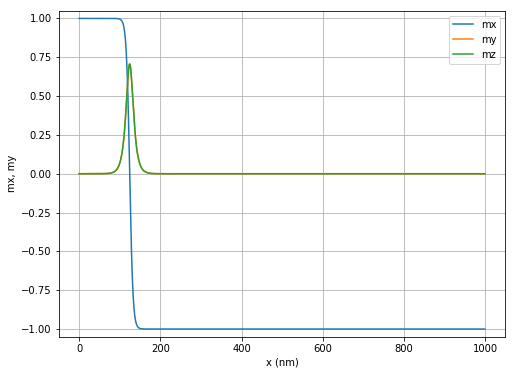

In [8]:
#NBVAL_IGNORE_OUTPUT
plot_magnetisation([['m0.npy', 'mx'], ['m0.npy', 'my'], ['m0.npy', 'mz']])

The DW is at the maximum value of $|m_z|$ or $|m_y|$. Consequently, the domain wall position is:

In [9]:
m0_z = np.load('m0.npy').reshape(-1, 3)[:, 2]
x = np.arange(len(m0_z))
index_max = np.argmax(np.abs(m0_z))

print('Maximum |m_z| at x = %s' % x[index_max])

Maximum |m_z| at x = 124


Using the obtained domain wall equilibrium state, we now simulate its motion in presence of a spin-polarised current.

In [10]:
#NBVAL_IGNORE_OUTPUT
excite_system(mesh, 1.5e-9, 151)

We plot once again to compare the initial state with the ones after a SP current was applied.

(0, 200)

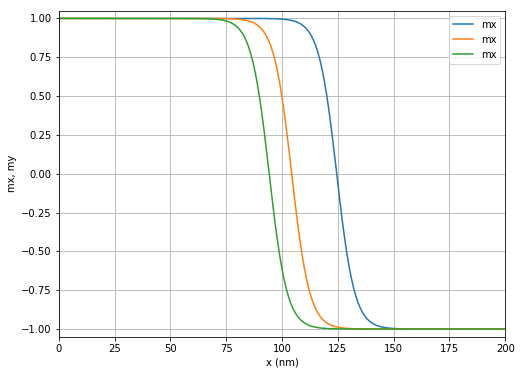

In [11]:
#NBVAL_IGNORE_OUTPUT
# We can plot the m_x component for a number snapshots
# to observe the DW motion
# We will plot the 100th and 150th files (we can also compute
# until the system reaches ~5 ns to improve the effect)
plot_magnetisation([['m0.npy', 'mx'],
                    ['dyn_npys/m_100.npy', 'mx'],
                    ['dyn_npys/m_150.npy', 'mx']])
plt.xlim([0, 200])